# Libraries

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CelebA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import os
import tqdm

from sklearn.manifold import TSNE

In [ ]:
# set seed
seed = 8
torch.manual_seed(seed)
np.random.seed(seed)

## CelebA


In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [7]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:17<00:00, 129MB/s]
100% 1.33G/1.33G [00:17<00:00, 79.7MB/s]


In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
# !cp ./celeba-dataset.zip ./drive/MyDrive/
!cp ./drive/MyDrive/celeba-dataset.zip .

In [ ]:
!unzip celeba-dataset.zip -d celeba

In [22]:
class CelebAAttrDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, target_trasform=None, split='train'):
        root_path = Path(root)
        self.images_path = root_path / 'img_align_celeba/img_align_celeba'
        self.attr_path = root_path / 'list_attr_celeba.csv'
        self.eval_partition_path = root_path / 'list_eval_partition.csv'
        self.transform = transform
        self.attr = self._load_attr()
        eval_partition = self._load_eval_partition()
        if split == 'all':
            partition = self.attr
        elif split == 'train':
            partition = eval_partition[eval_partition['partition'] == 0]
        elif split == 'val':
            partition = eval_partition[eval_partition['partition'] == 1]
        elif split == 'test':
            partition = eval_partition[eval_partition['partition'] == 2]
        else:
            raise ValueError('Invalid split value')

        self._set_partition(partition.index)
        self.idx2attr = {idx: attr for idx, attr in enumerate(self.attr.columns[1:])}
        self.attr2idx = {attr: idx for idx, attr in self.idx2attr.items()}

    def _set_partition(self, index):
        self.attr = self.attr.loc[index]

    def _set_attr(self, attr):
        self.attr = attr.copy()

    def _load_attr(self):
        return pd.read_csv(self.attr_path)

    def _load_eval_partition(self):
        return pd.read_csv(self.eval_partition_path)

    def __len__(self):
        return len(self.attr)

    def __getitem__(self, idx):
        img_name = self.attr.iloc[idx, 0]
        img_path = self.images_path / img_name
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        attr = self.attr.iloc[idx, 1:].values.astype(np.float32)
        return img, attr

In [25]:
group_names = ['c11', 'c12', 'c21', 'c22', 'o1', 'o2']

result_path = 'results/DINO_pics/'
os.makedirs(result_path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

celeba_dataset = CelebAAttrDataset(root='./celeba', split='train', transform=transform)

In [26]:
len(celeba_dataset), celeba_dataset[0][0].size()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(162770, torch.Size([3, 224, 224]))

Sampling groups:

In [27]:
df = celeba_dataset.attr.copy()
grouped_df = {}
for gender in [-1, 1]:
    gender_df = df[df['Male'] == gender]
    gender_name = 'man' if gender == 1 else 'woman'
    for hair_type in ['Black_Hair', 'Blond_Hair', 'Bald']:
        name = f"{gender_name}_{hair_type.split('_')[0].lower()}"
        hair_gender_df = gender_df[gender_df[hair_type] == 1]
        grouped_df[name] = hair_gender_df

[f'{group}: {len(group_df)}' for group, group_df in grouped_df.items()]

['woman_black: 18784',
 'woman_blond: 22880',
 'woman_bald: 9',
 'man_black: 20122',
 'man_blond: 1387',
 'man_bald: 3704']

# Dino

In [16]:
model_dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
model_dino.eval()

device = torch.device("cuda")
model_dino.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:06<00:00, 176MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [32]:
from torch.utils.data import DataLoader

grouped_embs = {}

for group, group_df in grouped_df.items():
    embs_list = []
    celeba_dataset._set_attr(group_df.sample(50, replace=True))
    celeba_dataloader = DataLoader(celeba_dataset, batch_size=128, shuffle=False)
    with torch.no_grad(), tqdm.tqdm(celeba_dataloader, total=len(celeba_dataloader)) as pbar:
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            embs = model_dino(imgs).squeeze().cpu().numpy()
            embs_list.append(embs)
    embs_list = np.concatenate(embs_list)
    grouped_embs[group] = embs_list

grouped_prototypes = {group: embs.mean(axis=0, keepdims=True) for group, embs in grouped_embs.items()}

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


In [57]:
import utils

euc_dist = {group: np.linalg.norm(embs - grouped_prototypes[group], axis=1) for group, embs in grouped_embs.items()}
euc_dist = np.concatenate(list(euc_dist.values()))
# all_embs = np.concatenate(list(grouped_embs.values()))
# euc_dist = np.array([np.linalg.norm(embs - proto, axis=1) for group, proto in grouped_prototypes.items()])
# euc_dist.shape

(6, 50)

In [39]:
embs_normalized = {group: embs / np.linalg.norm(embs, axis=1, keepdims=True) for group, embs in grouped_embs.items()}
prototypes_normalized = {group: prot / np.linalg.norm(prot) for group, prot in grouped_prototypes.items()}
cos_dist = {group: np.dot(embs, prototypes_normalized[group].T) for group, embs in embs_normalized.items()}
cos_dist = np.concatenate(list(cos_dist.values()))


In [45]:
embd_probs = {group: utils.softmax(dist) for group, dist in grouped_embs.items()}
proto_probs = {group: utils.softmax(dist) for group, dist in grouped_prototypes.items()}
cross_entropy_loss = {group: - np.dot(np.log(embd_probs[group]), proto_probs[group].T) for group in grouped_embs.keys()}
cross_entropy_loss = np.concatenate(list(cross_entropy_loss.values()))


ValueError: ignored

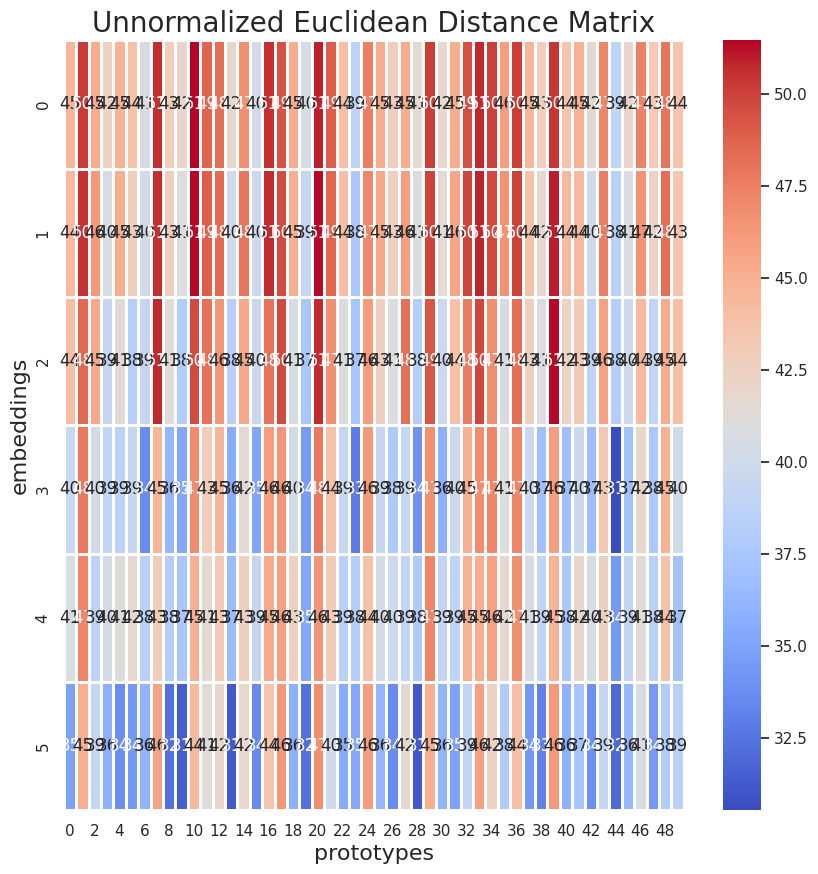

<Figure size 1000x1000 with 0 Axes>

In [59]:
result_path = 'results/DINO_pics/'
os.makedirs(result_path, exist_ok=True)
utils.plot_adj_mat(euc_dist, 'Unnormalized Euclidean Distance Matrix', result_path)
utils.plot_adj_mat(cos_dist, 'Cosine Similarity Matrix', result_path)
utils.plot_adj_mat(cross_entropy_loss, 'Cross-Entropy Matrix', result_path)

In [52]:
euc_dist[None,:].T

array([[34.702217],
       [31.95797 ],
       [44.320038],
       [37.556686],
       [33.911297],
       [32.454784],
       [37.963642],
       [36.45313 ],
       [37.283672],
       [34.202724],
       [42.692917],
       [38.52226 ],
       [36.18743 ],
       [42.761677],
       [34.94224 ],
       [37.08749 ],
       [32.333385],
       [32.9664  ],
       [29.852242],
       [39.06143 ],
       [34.74672 ],
       [33.00651 ],
       [38.706417],
       [45.18019 ],
       [48.568768],
       [42.208794],
       [35.34551 ],
       [40.50127 ],
       [32.204372],
       [35.744442],
       [31.518671],
       [34.211296],
       [30.058512],
       [41.565937],
       [34.03977 ],
       [31.553823],
       [31.22606 ],
       [31.711365],
       [29.91986 ],
       [35.520767],
       [32.00125 ],
       [38.109905],
       [41.21681 ],
       [33.93397 ],
       [38.478275],
       [38.385647],
       [36.093914],
       [31.323416],
       [37.86536 ],
       [34.371338],
